In [8]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1)

In [9]:
random_state = 666
np.random.seed(random_state)
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [10]:
########################Data augmentation, taken from https://www.kaggle.com/jiweiliu/fast-inplace-shuffle-for-augmentation
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [11]:
# ##############Principal Component Analysis Features

# pca2 = PCA(n_components=2)
# pca4 = PCA(n_components=4)
# pca8 = PCA(n_components=8)
# pca16 = PCA(n_components=16)
# # pca32 = PCA(n_components=32)

# temp = StandardScaler().fit_transform(df_train.drop(columns=['ID_code', 'target']).values)
# # pca2_train = pca2.fit(temp)
# # pca4_train = pca4.fit(temp)
# # pca8_train = pca8.fit(temp)
# # pca16_train = pca16.fit(temp)
# # pca32_train = pca32.fit(temp)

# temp2 = StandardScaler().fit_transform(df_test.drop(columns=['ID_code']).values)
# # pca2_test = pca2.fit(temp2)
# # pca4_test = pca4.fit(temp2)
# pca8_test = pca8.fit(temp2)
# pca16_test = pca16.fit(temp2)
# pca32_test = pca32.fit(temp2)
# #######Train
# columns = ['pca2_%i' % i for i in range(2)]
# df_pca2 = pd.DataFrame(pca2_train.transform(df_train.drop(columns=['ID_code', 'target'])), columns=columns, index=df_train.index)
# columns = ['pca4_%i' % i for i in range(4)]
# df_pca4 = pd.DataFrame(pca4_train.transform(df_train.drop(columns=['ID_code', 'target'])), columns=columns, index=df_train.index)
# columns = ['pca8_%i' % i for i in range(8)]
# df_pca8 = pd.DataFrame(pca8_train.transform(df_train.drop(columns=['ID_code', 'target'])), columns=columns, index=df_train.index)
# columns = ['pca16_%i' % i for i in range(16)]
# df_pca16 = pd.DataFrame(pca16_train.transform(df_train.drop(columns=['ID_code', 'target'])), columns=columns, index=df_train.index)

# ##########Test
# columns = ['pca2_%i' % i for i in range(2)]
# df_pca2_te = pd.DataFrame(pca2_test.transform(df_test.drop(columns=['ID_code'])), columns=columns, index=df_test.index)
# columns = ['pca4_%i' % i for i in range(4)]
# df_pca4_te = pd.DataFrame(pca4_test.transform(df_test.drop(columns=['ID_code'])), columns=columns, index=df_test.index)
# columns = ['pca8_%i' % i for i in range(8)]
# df_pca8_te = pd.DataFrame(pca8_test.transform(df_test.drop(columns=['ID_code'])), columns=columns, index=df_test.index)
# columns = ['pca16_%i' % i for i in range(16)]
# df_pca16_te = pd.DataFrame(pca16_test.transform(df_test.drop(columns=['ID_code'])), columns=columns, index=df_test.index)



# target = df_train['target'].copy(deep=True)
# ID_code_train = df_train['ID_code'].copy(deep=True)
# ID_code_test = df_test['ID_code'].copy(deep=True)
# # df_pca2.head()
# pca95 = PCA(.95)
# pca95 = pca95.fit(temp)
# columns = ['pca_%i' % i for i in range(pca95.n_components_)]
# df_train = pd.DataFrame(pca95.transform(df_train.drop(columns=['ID_code', 'target'])), columns=columns, index=df_train.index)
# pca95 = pca95.fit(temp2)
# columns = ['pca_%i' % i for i in range(pca95.n_components_)]
# df_test = pd.DataFrame(pca95.transform(df_test.drop(columns=['ID_code'])), columns=columns, index=df_test.index)

In [12]:
########################Additional feautres

def wave_length(x):
    ###Highly experimental
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    return sum(abs(xn_i2-xn))
    
def norm_entropy(x):
    tresh = 3
    return sum(np.power(abs(x),tresh))

def SRAV(x):    
    SRA = sum(np.sqrt(abs(x)))
    return np.power(SRA/len(x),2)
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [13]:
######################Additional statistical features
idx = features = df_train.columns.values[2:202]
for df in [df_test, df_train]:
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)
    df['q1'] = df[idx].quantile(0.25, axis=1)
    df['q3'] = df[idx].quantile(0.75, axis=1)
    df['IQR'] = df['q3'] - df['q1']
    ###Experimental feature
    df['wl'] = df[idx].apply(lambda x: wave_length(x), axis=1)
    df['ne'] = df[idx].apply(lambda x: norm_entropy(x), axis=1)
    df['SRAV'] = df[idx].apply(lambda x: SRAV(x), axis=1)
    
####################Additional polynomial features
    df['mix1'] = df['var_80']*df['var_108']
    df['mix2'] = df['var_9']*df['var_13']
    df['mix3'] = df['var_184']*df['var_133']
    df['mix4'] = df['var_174']*df['var_18']
    df['mix5'] = df['var_2']*df['var_6']
    
    df['mix12'] = df['var_80']*df['var_108']*df['var_9']
    df['mix23'] = df['var_9']*df['var_13']*df['var_184']
    df['mix34'] = df['var_184']*df['var_133']*df['var_174']
    df['mix45'] = df['var_174']*df['var_18']*df['var_2']
    df['mix15'] = df['var_2']*df['var_6']*df['var_80']
    
    
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,mix1,mix2,mix3,mix4,mix5,mix12,mix23,mix34,mix45,mix15
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,192.561807,3.301652,169.700303,79.518751,60.953991,1106.652703,85.314014,3149.943075,946.917241,831.826931
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,35.532221,68.023989,158.965212,236.063100,77.897543,287.281560,1533.539607,4811.002669,3271.551290,198.342724
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,106.087530,43.527061,152.904860,120.733650,83.871287,631.486024,1004.891846,3926.902626,1458.522861,626.761743
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,11.229838,98.695948,-3.337946,235.126248,52.305914,92.590013,-45.785050,-49.229030,2104.897194,41.002606
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,41.684935,60.578737,78.416990,120.530972,76.481561,320.073607,717.876205,1448.244183,1551.788046,226.370125


In [14]:
# df_train = pd.concat([df_train, df_pca2, df_pca4, df_pca8, df_pca16], axis=1)

# df_test = pd.concat([df_test, df_pca2_te, df_pca4_te, df_pca8_te, df_pca16_te], axis=1)

# df_train = pd.concat([df_train, target, ID_code_train], axis=1)
# df_test = pd.concat([df_test, ID_code_test], axis=1)

In [15]:
params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : random_state,
    "verbosity" : 1,
    "seed": random_state
}

In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
oof = df_train[['ID_code', 'target']]
oof = df_train[['ID_code', 'target']]
oof['predict'] = 0
predictions = df_test[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

In [17]:
features = [col for col in df_train.columns if col not in ['target', 'ID_code']]
X_test = df_test[features].values

In [24]:
######Based on https://www.kaggle.com/adrianlievano/light-gbm-with-stratified-kfold
######Only training once per fold

for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train, df_train['target'])):
    X_train, y_train = df_train.iloc[trn_idx][features], df_train.iloc[trn_idx]['target']
    X_valid, y_valid = df_train.iloc[val_idx][features], df_train.iloc[val_idx]['target']
    
    p_valid,yp = 0,0
    X_t, y_t = X_train.values, y_train.values
    X_t = pd.DataFrame(X_t)
    X_t = X_t.add_prefix('var_')

    trn_data = lgb.Dataset(X_t, label=y_t)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    evals_result = {}
    lgb_clf = lgb.train(params,
                    trn_data,
                    100000,
                    valid_sets = [trn_data, val_data],
                    early_stopping_rounds=500,
                    verbose_eval = 1000,
                    evals_result=evals_result
                   )
    p_valid += lgb_clf.predict(X_valid)
    yp += lgb_clf.predict(X_test)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
    predictions['fold{}'.format(fold+1)] = yp

Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.895542	valid_1's auc: 0.877955
[2000]	training's auc: 0.911075	valid_1's auc: 0.889441
[3000]	training's auc: 0.920283	valid_1's auc: 0.894816
[4000]	training's auc: 0.927264	valid_1's auc: 0.897985
[5000]	training's auc: 0.932943	valid_1's auc: 0.899618
[6000]	training's auc: 0.938084	valid_1's auc: 0.900536
[7000]	training's auc: 0.942717	valid_1's auc: 0.900916
Early stopping, best iteration is:
[7066]	training's auc: 0.942996	valid_1's auc: 0.900943
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.895711	valid_1's auc: 0.879999
[2000]	training's auc: 0.910985	valid_1's auc: 0.891077
[3000]	training's auc: 0.920426	valid_1's auc: 0.895723
[4000]	training's auc: 0.927421	valid_1's auc: 0.897581
[5000]	training's auc: 0.933218	valid_1's auc: 0.898716
[6000]	training's auc: 0.938213	valid_1's auc: 0.899208
[7000]	training's auc: 0.942778	valid_1's auc: 0.899526

In [25]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.841086837, std: 0.059451393. All auc: 0.899458204.


In [26]:
# submission
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('lgb_all_predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv("lgb_submission.csv", index=False)

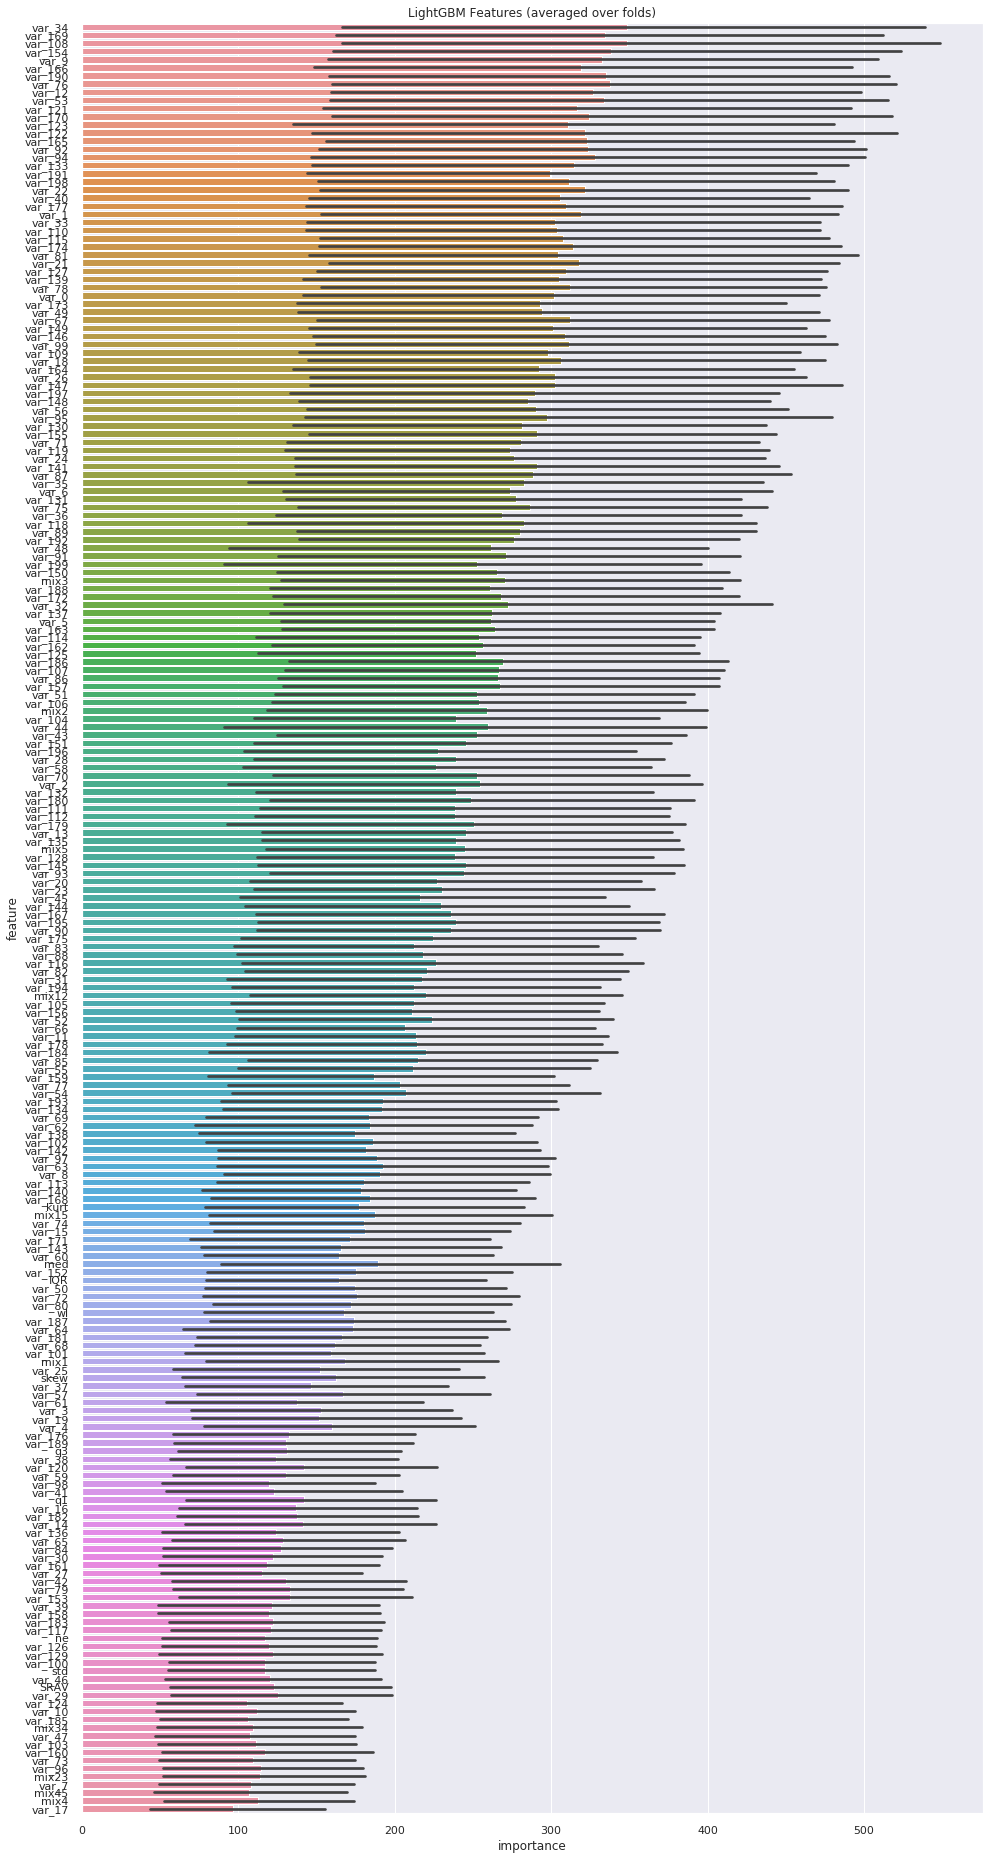

In [27]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.savefig('lgbm_importances.png')